In [2]:
import gooseberry as gs

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Ellipse
import numpy as np

import jax
import jax.numpy as jnp
from functools import partial

from dynamics import QQT
from tools import BlindColours, zero_balanced_weights
import pandas as pd

ModuleNotFoundError: No module named 'sklearn'

In [3]:
bc = BlindColours(False)
blind_colours = bc.get_colours()
div_cmap = bc.get_div_cmap()
colour_steps = bc.get_colour_steps()

NameError: name 'BlindColours' is not defined

In [4]:
def logger(params, X, Y, f):
    w2w1 = params["network"]["layer-1"]["w"][0] @ params["network"]["layer-0"]["w"][0]
    Y_hat = params["network"]["layer-1"]["w"][0] @ f(params["network"]["layer-0"]["w"][0] @ X.T)
    loss = 0.5 * np.mean(np.sum((Y_hat.T - Y)**2, axis=1))
    return w2w1, loss

In [5]:
#TODO:

#Defining the forgetting Formula


#Forgetting F on task T_i when training on task T_k after having trained the network on task T_j
#F_i(T_j, T_k) = L_i(T_k) - L_i(T_j)

#1. Define Forgetting Formula.

#2. Do Gradient Descent and Plot Forgetting

#3. Plot Forgetting using QQt

#4. Plot rate of forgetting using Gradient Descent

#5. Plot rate of forgetting using QQt

In [6]:
def get_loss(ws, task):
    data, lables = task(None)
    return 0.5 * np.mean(np.sum((ws @ data.T - labels.T)**2, axis=1))

In [7]:
def balanced_weights(in_dim, hidden_dim, out_dim, c):

    #random number bigger than c:
    a = np.random.exponential(scale = 5) + c 
    b = np.sqrt(a*a - c)

    #TODO: not sure which dimension, doesnt work for hidden_dim > min(out_dim, in_dim)
    S_1 = a * np.eye(max(hidden_dim, in_dim))[:hidden_dim, :in_dim]
    S_2 = b * np.eye(max(out_dim, hidden_dim))[:out_dim, :hidden_dim] 

    random_matrix_one = np.random.rand(hidden_dim, hidden_dim)
    random_matrix_two = np.random.rand(in_dim, in_dim)
    random_matrix_three = np.random.rand(out_dim, out_dim)

    q_one, _ = np.linalg.qr(random_matrix_one)
    q_two, _ = np.linalg.qr(random_matrix_two)
    q_three, _ = np.linalg.qr(random_matrix_three)

    U_1 = q_one 
    V_2 = q_one 
    V_1 = q_two
    U_2 = q_three

    W1 = U_1 @ S_1 @ (V_1.T)
    W2 = U_2 @ S_2 @ (V_2.T)

    return W1, W2 

In [8]:
def training_data(data_x, data_y):
    return data_x, data_y

In [9]:

in_dim = 4
hidden_dim = 5
out_dim = 3

batch_size = 25
learning_rate = 0.05
training_steps = 6000

initial_weight_scale = 0.0001

training_datas = []

datas = []
labels = []
whitened_datas = []

for i in range(3):
    init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, 0.3)
    training_data, _, _ = gs.datasets.RandomRegression(batch_size, in_dim, out_dim, [gs.datasets.Whiten()])
    training_datas.append(training_data)
    

# for td in training_datas:
#     data, label = td(None)
#     datas.append(data)
#     labels.append(label)

# for X in datas:
#     scaler = StandardScaler()
#     X_standardized = scaler.fit_transform(X)

#     pca = PCA(whiten=True)
#     X_whitened = pca.fit_transform(X_standardized)
#     whitened_datas.append(X_whitened)


# for i in range(3):
#     training_datas[i] = lambda _: (whitened_datas[i], labels[i])

losses = [[] for _ in range(3)]
analytical_losses = [[] for _ in range(3)]

logs = jax.jit(partial(logger, f=gs.nonlinearities.Identity()))

ws = []
analyticals = []
for i, training_data in enumerate(training_datas):
    task = gs.tasks.FullBatchLearning(training_data)
    optimiser = gs.GradientDescent(learning_rate)
    loss = gs.MeanSquaredError()

    if i == 0:
        init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, initial_weight_scale)
    else:
        init_w1, init_w2 = params["network"]["layer-0"]["w"][0], params["network"]["layer-1"]["w"][0]
    
    mlp = gs.Network([
        gs.Linear(hidden_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w1)),
        gs.Linear(out_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w2))
    ])
    
    trainer = gs.Trainer(task, mlp, loss, optimiser)
    state, params = gs.assemble(1)
    
    for training_step in range(training_steps):
        for j, data in enumerate(training_datas):
            X, Y = data(None)
            w2w1, loss = logs(params, X, Y)
            losses[j].append(loss)
        ws.append(w2w1)
        
        state, params, loss = trainer(state, params)
    
    X, Y = training_datas[i](None)
    analytical = QQT(init_w1, init_w2, X.T, Y.T, True)
    next = np.asarray([analytical.forward(learning_rate) for _ in range(training_steps)])
    analyticals.extend(np.asarray([analytical.forward(learning_rate) for _ in range(training_steps)]))
    



    w2w1s = np.asarray(next)

    for cur, data in enumerate(training_datas):
        curr_X, curr_Y = data(None)
        anal_loss = 0.5 * (out_dim / batch_size) * np.mean(np.sum((next @ curr_X.T - curr_Y.T)**2, axis=2), axis=1)
        analytical_losses[cur].extend(anal_loss)


ws = np.asarray(ws)
losses = np.asarray(losses)
analytical_losses = np.asarray(analytical_losses)
analyticals = np.asarray(analyticals)

NameError: name 'zero_balanced_weights' is not defined

In [10]:
plt.plot(losses[0])

plt.title('Loss Evolution for Tasks i, j, and k')
plt.xlabel('Iterations')
plt.ylabel('Loss (on task i)')

plt.axvline(x=6000, color='gray', linestyle='--')
plt.axvline(x=12000, color='gray', linestyle='--')
plt.xticks([0, 6000, 12000, len(losses[0]) - 1], ['0', 'Task i', 'Task j', 'Task k'])

NameError: name 'losses' is not defined

In [11]:

in_dim = 3
hidden_dim = 3
out_dim = 3

batch_size = 25
learning_rate = 0.05
training_steps = 6000

initial_weight_scale = 0.0001

training_datas = []

datas = []
labels = []
whitened_datas = []


for i in range(3):
    init_w1, init_w2 = balanced_weights(in_dim, hidden_dim, out_dim, 0.3)

    
    training_data, _, _ = gs.datasets.RandomRegression(batch_size, in_dim, out_dim, [gs.datasets.Whiten()])
    training_datas.append(training_data)



#Just feed tasks something esle


losses = [[] for _ in range(3)]
analytical_losses = [[] for _ in range(3)]

logs = jax.jit(partial(logger, f=gs.nonlinearities.Identity()))

ws = []
analyticals = []
for i, training_data in enumerate(training_datas):
    task = gs.tasks.FullBatchLearning(training_data)
    optimiser = gs.GradientDescent(learning_rate)
    loss = gs.MeanSquaredError()

    if i == 0:
        init_w1, init_w2 = balanced_weights(in_dim, hidden_dim, out_dim, 0.1)
    else:
        init_w1, init_w2 = params["network"]["layer-0"]["w"][0], params["network"]["layer-1"]["w"][0]
    
    mlp = gs.Network([
        gs.Linear(hidden_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w1)),
        gs.Linear(out_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w2))
    ])
    
    trainer = gs.Trainer(task, mlp, loss, optimiser)
    state, params = gs.assemble(1)
    
    for training_step in range(training_steps):
        for j, data in enumerate(training_datas):
            X, Y = data(None)
            w2w1, loss = logs(params, X, Y)
            losses[j].append(loss)
        ws.append(w2w1)
        
        state, params, loss = trainer(state, params)
    
    # X, Y = training_datas[i](None)
    # analytical = QQT(init_w1, init_w2, X.T, Y.T, True)
    # next = np.asarray([analytical.forward(learning_rate) for _ in range(training_steps)])
    # analyticals.extend(np.asarray([analytical.forward(learning_rate) for _ in range(training_steps)]))
    



    # w2w1s = np.asarray(next)

    # for cur, data in enumerate(training_datas):
    #     curr_X, curr_Y = data(None)
    #     anal_loss = 0.5 * (out_dim / batch_size) * np.mean(np.sum((next @ curr_X.T - curr_Y.T)**2, axis=2), axis=1)
    #     analytical_losses[cur].extend(anal_loss)


ws = np.asarray(ws)
losses = np.asarray(losses)
# analytical_losses = np.asarray(analytical_losses)
# analyticals = np.asarray(analyticals)

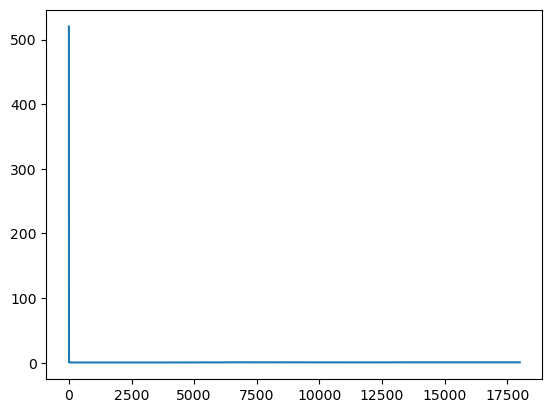

In [12]:
plt.plot(losses[0])

<Axes: >

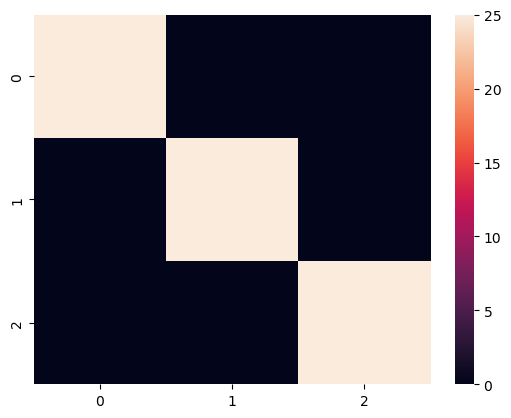

In [13]:
t = training_datas[0](None)[0]

sns.heatmap(t.T @ t)

#formula column vectors code uses rows

#implement your own code

In [14]:
#call assemble before
#implement those methods using pytorch


In [15]:
ws

array([[[ 1.02397776e+00,  1.76984253e+01, -5.68480158e+00],
        [ 9.01215935e+00,  4.50691986e+00,  1.56546621e+01],
        [ 1.62582989e+01, -3.61291718e+00, -8.31951809e+00]],

       [[-1.20460009e-02,  1.16354197e-01, -2.78459080e-02],
        [ 5.02849221e-02,  3.96717750e-02,  7.31302127e-02],
        [ 6.80275783e-02,  9.87864099e-03, -3.06520564e-03]],

       [[-1.30918529e-02,  1.17834687e-01, -2.76966002e-02],
        [ 5.01091667e-02,  4.08974402e-02,  7.27089271e-02],
        [ 6.74101487e-02,  1.16940876e-02, -1.22499617e-03]],

       ...,

       [[ 1.20627895e-01,  9.29373205e-02,  9.36461538e-02],
        [-1.17088690e-01, -8.59188661e-02, -1.26848817e-01],
        [ 8.83748904e-02,  1.24027655e-02, -1.70806617e-01]],

       [[ 1.20627910e-01,  9.29373130e-02,  9.36461613e-02],
        [-1.17088683e-01, -8.59188810e-02, -1.26848817e-01],
        [ 8.83749053e-02,  1.24027655e-02, -1.70806617e-01]],

       [[ 1.20627917e-01,  9.29372907e-02,  9.36461687e-02],
 

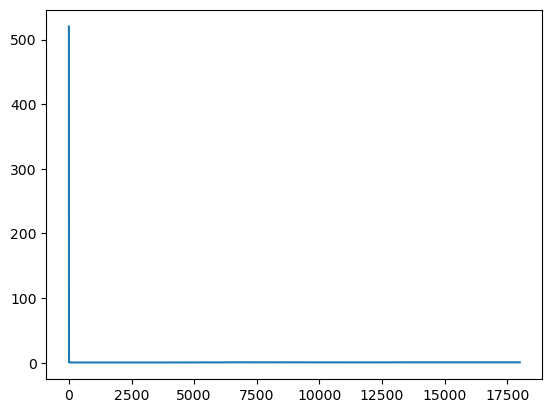

In [16]:


# plt.axvline(x=6000, color='gray', linestyle='--')
# plt.axvline(x=12000, color='gray', linestyle='--')
plt.plot(losses[0])


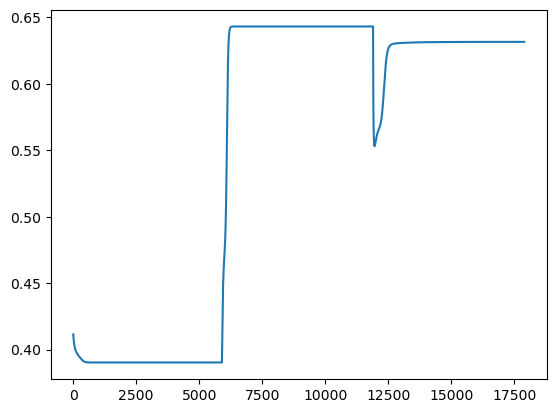

In [17]:
plt.plot(losses[0][100:])

In [18]:
training_datas[0]

functools.partial(<function Dataset.advance_training at 0x11d3fb7e0>, data=Array([[ 2.1041293 , -0.72435415, -0.22289653],
       [ 0.04194337,  0.7704179 , -0.84417087],
       [ 0.57535833, -0.3235659 , -1.0128741 ],
       [-0.82804203,  0.3786645 ,  0.08414545],
       [ 0.47742885,  0.43264782,  1.8909785 ],
       [-0.88973165, -3.2744915 ,  0.06605058],
       [-0.09345888,  0.82561356, -0.35146368],
       [-0.7709972 ,  0.9107065 , -0.7044364 ],
       [-0.8752964 , -0.31672662, -0.4658547 ],
       [-1.0528693 , -0.28229746, -1.1593554 ],
       [ 0.24639304, -0.12586832,  0.30102435],
       [ 2.0405073 , -1.2955315 ,  0.5170591 ],
       [-0.7138172 ,  0.9104135 ,  1.5213896 ],
       [ 1.0723517 ,  0.54888856,  0.9747561 ],
       [-1.8785577 ,  0.10567895,  1.3256845 ],
       [ 0.7371103 ,  0.413977  , -1.0217959 ],
       [-0.22927947, -0.47338223,  0.3422561 ],
       [-0.29088193, -0.70169413,  0.09242441],
       [-0.12116735, -0.7591849 ,  1.4586489 ],
       [-0.98

In [19]:
#Measuring forgetting

#loss on task I from fully training on task J
loss_j = losses[0][6000*2]
analytical_loss_j = analytical_losses[0][6000*2]


fs = []
analytical_fs = []

for i in range(12000, 18000):
    fs.append(losses[0][i] - loss_j)
    analytical_fs.append(analytical_losses[0][i] - analytical_loss_j)



IndexError: list index out of range

In [ ]:
analyticals.shape

analyticals[0]



array([[-0.19591183, -0.03907579, -0.07610647,  0.05918923,  0.0713244 ],
       [-0.05122751,  0.05204084, -0.08404649, -0.06723805, -0.10411619],
       [ 0.06134075, -0.09255351,  0.01677601,  0.10069314, -0.055634  ],
       [-0.10535398, -0.05792954, -0.031043  ,  0.02109872, -0.01066482],
       [ 0.05048401, -0.16628119,  0.05055009,  0.10054721, -0.01160201],
       [ 0.09835255,  0.0101964 ,  0.11607629,  0.078205  , -0.02687383]])

In [ ]:
analyticals[0].shape

(6, 5)

In [ ]:
ls = []
for i in range(18000):
    ls.append()

TypeError: list.append() takes exactly one argument (0 given)

In [ ]:
analyticals

[]

In [ ]:
#Calculate forgetting a different way (as in the supplementary material)


sigma_yx_i = analyticals[6000]
sigma_yx_j = analyticals[12000]


forgetting_representations = []

for i in range(12000, 18000):
    curr = np.linalg.norm(ws[i] - sigma_yx_i, 'fro')**2 - np.linalg.norm(sigma_yx_j - sigma_yx_i, 'fro')**2
    forgetting_representations.append(curr * 0.5 * (out_dim / batch_size))




In [ ]:
task_i

NameError: name 'task_i' is not defined

In [ ]:
task_i = training_datas[0]
task_j = training_datas[1]
task_k = training_datas[2]

data_i, label_i = task_i(None)

test_losses = []

for weights in ws: 
    test_losses.append(0.5 * (out_dim / batch_size) * np.linalg.norm(weights @ data_i.T - label_i.T))



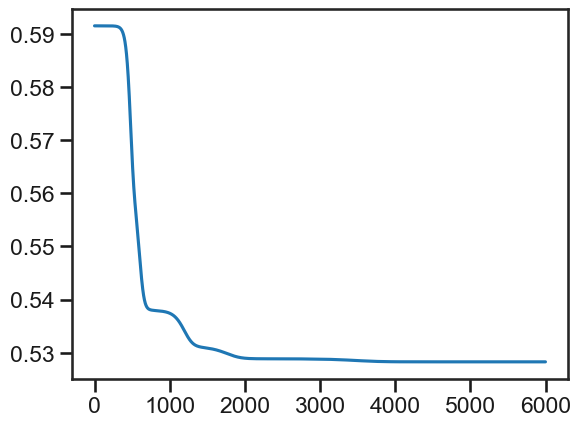

In [ ]:
plt.plot(test_losses)

In [ ]:
import seaborn as sns

<Axes: >

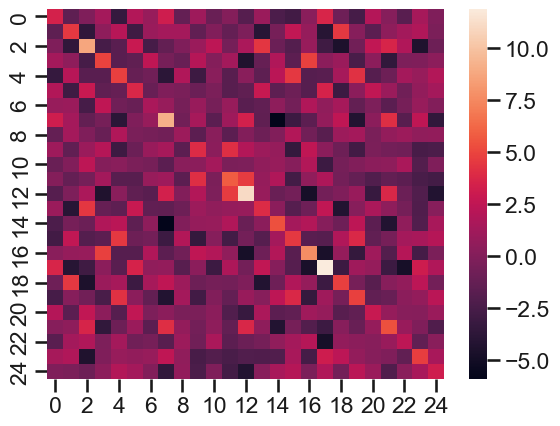

In [ ]:
sns.heatmap(data_i @ data_i.T)

In [20]:
ws[0].shape

(3, 3)

In [21]:
data_i.shape



NameError: name 'data_i' is not defined

In [23]:
data_i, label_i = task_i(None)

In [24]:
plt.plot(forgetting_representations)



NameError: name 'forgetting_representations' is not defined

In [25]:
x = [np.linalg.norm(a - sigma_yx_i, 'fro')**2 for a in ws]

NameError: name 'sigma_yx_i' is not defined

In [26]:
plt.plot(x)

NameError: name 'x' is not defined

In [27]:
print(sigma_yx_i)

NameError: name 'sigma_yx_i' is not defined

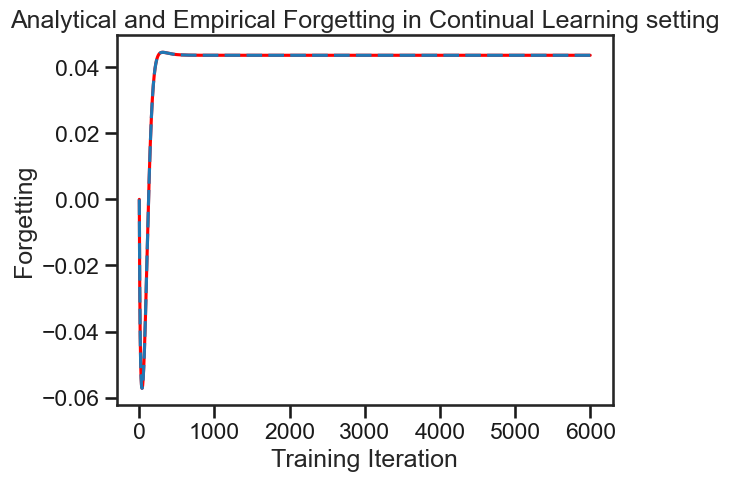

In [32]:
plt.title



plt.plot(analytical_fs, color='red', label='Empirical')
plt.plot(analytical_fs, '--', dashes = (5, 2), label='Analytical')

plt.xlabel('Training Iteration')
plt.ylabel('Forgetting')

plt.title('Analytical and Empirical Forgetting in Continual Learning setting')
plt.show()




In [33]:
dev = np.gradient(analytical_fs)

In [1]:

# Plot the derivative



plt.figure()
plt.title('Rate of Forgetting through Training')
plt.plot(dev, lynestyle='--', color='grey', label='Analytical')
plt.xlabel('Training Iteration')
plt.ylabel('Rate of Forgetting')
plt.legend()

NameError: name 'plt' is not defined

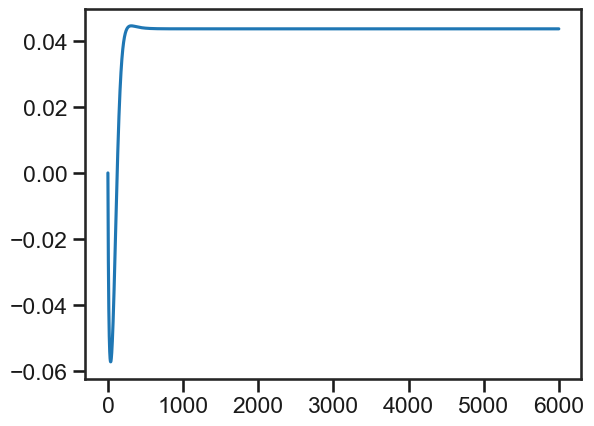

In [27]:
plt.plot(analytical_fs)

#TODO forgetting plot

In [30]:
plt.plot(fs)

NameError: name 'fs' is not defined

In [31]:
slope = pd.Series(np.gradient(fs), name='slope')
slope_analytical = pd.Series(np.gradient(analytical_fs), name='slope_analytical')

NameError: name 'fs' is not defined

In [32]:
slope.plot()

NameError: name 'slope' is not defined

In [33]:
slope_analytical.plot()

NameError: name 'slope_analytical' is not defined

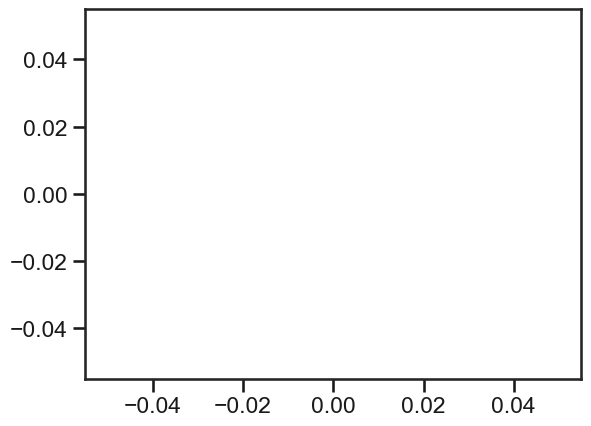

In [34]:
plt.plot(analytical_losses[0], label ='analytical')

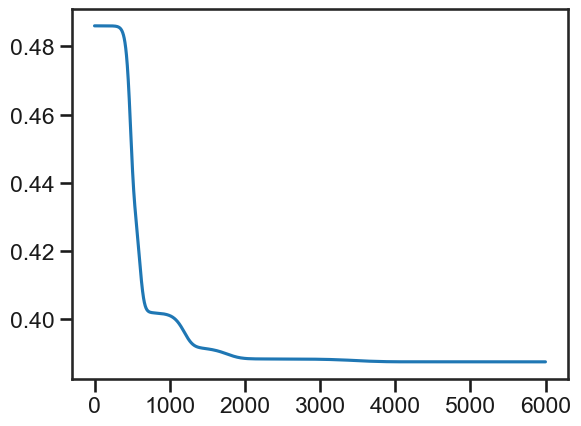

In [35]:
plt.plot(losses[0], label='empirical')

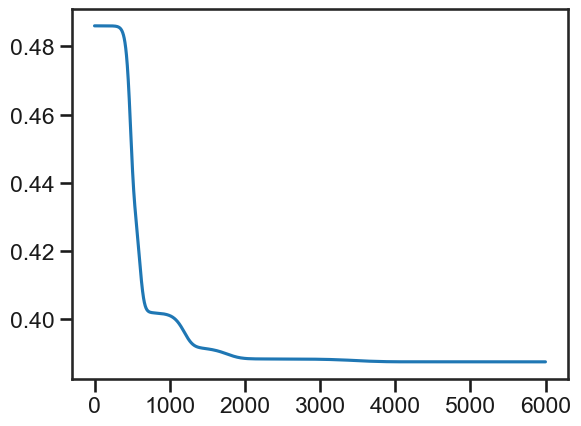

In [36]:
plt.plot(losses[0])

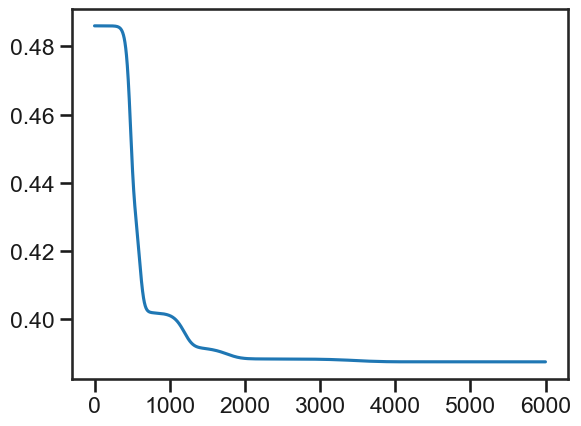

In [37]:
plt.plot(losses[0])

In [38]:
losses

[[Array(0.48605323, dtype=float32),
  Array(0.48605323, dtype=float32),
  Array(0.48605323, dtype=float32),
  Array(0.48605326, dtype=float32),
  Array(0.48605326, dtype=float32),
  Array(0.48605326, dtype=float32),
  Array(0.48605326, dtype=float32),
  Array(0.48605326, dtype=float32),
  Array(0.48605326, dtype=float32),
  Array(0.48605326, dtype=float32),
  Array(0.48605326, dtype=float32),
  Array(0.48605326, dtype=float32),
  Array(0.48605326, dtype=float32),
  Array(0.48605323, dtype=float32),
  Array(0.48605323, dtype=float32),
  Array(0.48605323, dtype=float32),
  Array(0.48605323, dtype=float32),
  Array(0.48605323, dtype=float32),
  Array(0.48605323, dtype=float32),
  Array(0.48605323, dtype=float32),
  Array(0.48605323, dtype=float32),
  Array(0.48605323, dtype=float32),
  Array(0.48605323, dtype=float32),
  Array(0.48605323, dtype=float32),
  Array(0.48605323, dtype=float32),
  Array(0.48605323, dtype=float32),
  Array(0.48605323, dtype=float32),
  Array(0.48605323, dtype=fl

In [39]:
#once you have all analyticals, calculate the losses

In [40]:
#once you have all losses calculate forgetting in simple way for both analytical and empirical

In [41]:
#calcualte rate of forgetting

In [42]:
#calculate forgetting in complex way

In [43]:
#do everything again for balanced weights

In [44]:
task_i = training_datas[0]
task_j = training_datas[1]
task_k = training_datas[2]

In [45]:
data, labels = task_i(None)

In [46]:
data

Array([[-1.0577182 , -0.47036108, -0.22574325, -1.3412032 ,  0.4667125 ],
       [ 0.21118009, -0.68433833, -1.151691  ,  1.0024155 , -1.2706497 ],
       [ 1.8195599 ,  1.2590564 ,  0.7861528 , -1.732971  ,  0.39915326],
       [-1.4094265 ,  0.9138225 , -1.3973076 ,  0.12887245,  0.30018348],
       [ 0.383505  ,  0.10841314,  0.82612026,  1.6067158 , -1.1616478 ],
       [-0.34631407,  0.05680029,  1.303547  , -1.3754566 , -0.01407001],
       [-0.8443076 , -0.02663388, -0.8674164 ,  0.23729871,  0.09834968],
       [ 0.15868512, -2.3509915 , -1.3237491 , -1.2638342 ,  0.4334649 ],
       [ 0.39704415, -0.10109457,  0.19136886,  0.35871014, -0.82759285],
       [ 0.07763459,  0.380438  , -0.98092455, -0.23684245,  1.6575681 ],
       [ 0.71476847,  0.8851092 , -0.18832384, -0.09619175, -0.1779211 ],
       [ 0.1738714 , -0.06734181, -0.60806644,  0.7149775 ,  2.2024977 ],
       [ 2.20522   , -1.5662628 ,  0.3471105 ,  0.7825517 ,  1.7283713 ],
       [ 0.2586917 ,  0.71420336,  1.1

In [47]:
#I have the data, just have to calculate the loss

def loss(ws, task):
    data, labels = task(None)
    return 0.5 * np.mean(np.sum((ws @ data.T - labels.T)**2, axis=1))

def task_loss(taskj, taski):
    data_j, labels_j = task_j(None)
    data_i, labels_i = task_i(None)

    sigma_yx_j = labels_j.T @ data_j 
    print(labels_j)
    print(data_j)

    return 0.5 * np.mean(np.sum((sigma_yx_j @ data_i - labels_i)**2, axis=1))

    
    

def forgetting(ws, task_i, task_j):
    data_i, labels_i = task_i(None)
    data_j, labels_j = task_j(None)

    # sigma_yx_k = ws
    # sigma_yx_i = labels_i @ data_i
    # sigma_yx_j = labels_j @ data_j
    return 0.5 * loss(ws, task_i)

    #return 1/2 * (loss(ws, task_i) - task_loss(task_j, task_i))
    



In [48]:
data_j, labels_j = task_j(None)

In [49]:
labels_j.T @ data_j

Array([[-0.0440895 ,  2.280757  , -1.3506068 , -0.5767474 ,  0.99384177],
       [-0.27133894, -2.6620836 , -1.2298298 , -0.12672545, -3.2354295 ],
       [-0.09608925, -3.2934647 ,  2.0545368 ,  4.730593  , -0.58212054],
       [ 1.1272944 , -3.4257312 , -0.21057709,  1.2877712 ,  0.18849893],
       [ 0.79945016,  0.97082585,  1.5724329 ,  2.0556357 , -0.71207243],
       [ 2.0122187 , -0.6657979 , -0.3956221 , -2.3972788 ,  1.4553988 ]],      dtype=float32)

In [50]:
data_j.shape

(25, 5)

In [51]:
labels_j.shape

(25, 6)

In [52]:
labels_j

Array([[ 6.42018318e-01,  4.45016511e-02,  1.18390381e-01,
        -4.12489861e-01,  5.46372116e-01, -4.07017648e-01],
       [ 5.67357957e-01,  3.81290950e-02,  1.29807964e-01,
        -6.49431825e-01,  6.58891350e-02, -2.69623369e-01],
       [-6.93762898e-01,  2.28418410e-03, -5.06210625e-02,
        -1.10527432e+00, -1.90123305e-01,  2.36177355e-01],
       [ 2.95693606e-01, -1.42139062e-01,  4.38933343e-01,
         5.08877814e-01, -3.01584154e-01,  2.82492757e-01],
       [-1.86349720e-01, -8.76022398e-01,  1.70638606e-01,
         1.59205839e-01, -2.12459475e-01,  2.49449089e-01],
       [ 1.70525581e-01,  2.83342078e-02,  1.72347844e-01,
        -1.88181192e-01, -8.68517280e-01, -2.04150170e-01],
       [ 8.40745643e-02,  4.57846940e-01,  3.22004080e-01,
         5.92625618e-01,  3.94135624e-01, -1.46901834e+00],
       [ 9.49479814e-04, -3.20501208e-01,  3.04165006e-01,
         2.33044103e-01, -1.82877198e-01, -8.08006972e-02],
       [ 1.63581148e-01, -7.08201230e-01,  1.753

In [53]:
task_i = training_datas[0]
task_j = training_datas[1]
task_k = training_datas[2]


forgettings = []
for w in ws:
    forgettings.append(forgetting(ws=ws, task_i=task_i, task_j=task_j))

print(forgettings)

TypeError: unsupported operand type(s) for @: 'list' and 'ArrayImpl'

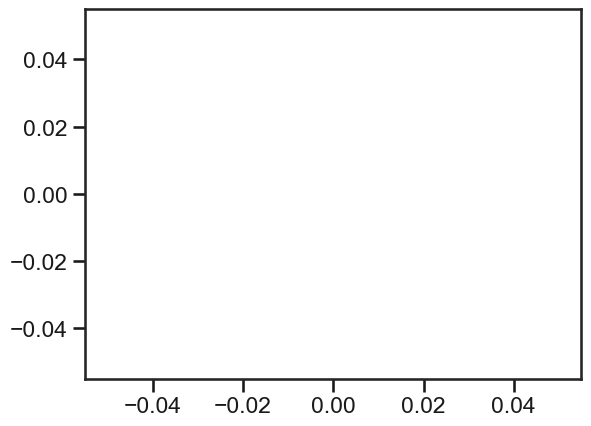

In [54]:
plt.plot(forgettings)

In [55]:
analyticals

[]

In [56]:
#The minimum loss one task is at the end of training, so just take it at that index




IndexError: list index out of range

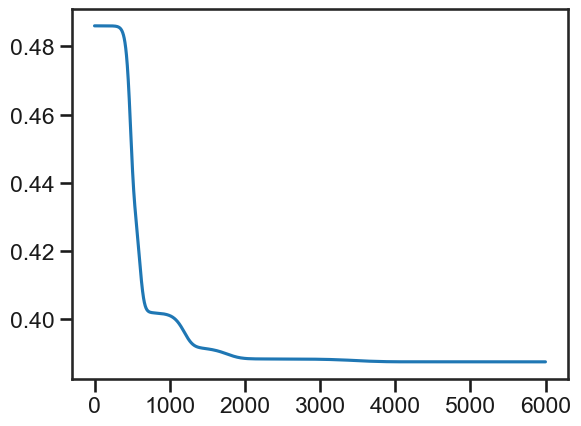

In [57]:
plt.plot(losses[0])


loss_j = losses[0][6000*2]


fs = []

for i in range(12000, 18000):
    fs.append(losses[0][i] - loss_j)

In [58]:
plt.plot(fs)

NameError: name 'fs' is not defined

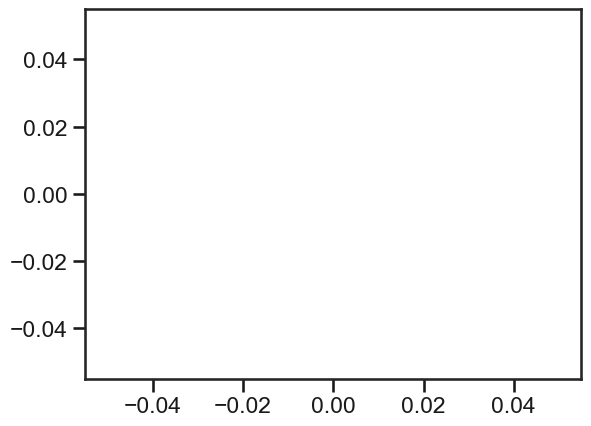

In [59]:
plt.plot(losses[0][12000:])

In [60]:
losses

[[Array(0.48605323, dtype=float32),
  Array(0.48605323, dtype=float32),
  Array(0.48605323, dtype=float32),
  Array(0.48605326, dtype=float32),
  Array(0.48605326, dtype=float32),
  Array(0.48605326, dtype=float32),
  Array(0.48605326, dtype=float32),
  Array(0.48605326, dtype=float32),
  Array(0.48605326, dtype=float32),
  Array(0.48605326, dtype=float32),
  Array(0.48605326, dtype=float32),
  Array(0.48605326, dtype=float32),
  Array(0.48605326, dtype=float32),
  Array(0.48605323, dtype=float32),
  Array(0.48605323, dtype=float32),
  Array(0.48605323, dtype=float32),
  Array(0.48605323, dtype=float32),
  Array(0.48605323, dtype=float32),
  Array(0.48605323, dtype=float32),
  Array(0.48605323, dtype=float32),
  Array(0.48605323, dtype=float32),
  Array(0.48605323, dtype=float32),
  Array(0.48605323, dtype=float32),
  Array(0.48605323, dtype=float32),
  Array(0.48605323, dtype=float32),
  Array(0.48605323, dtype=float32),
  Array(0.48605323, dtype=float32),
  Array(0.48605323, dtype=fl

In [61]:
slope = pd.Series(np.gradient(fs), name='slope')

NameError: name 'fs' is not defined

In [62]:
slope.plot()

NameError: name 'slope' is not defined

In [63]:
fs_dev = get_derivatives(fs)

NameError: name 'get_derivatives' is not defined

In [64]:
plt.plot(fs_dev)

NameError: name 'fs_dev' is not defined

In [65]:
data_i

Array([[-1.0577182 , -0.47036108, -0.22574325, -1.3412032 ,  0.4667125 ],
       [ 0.21118009, -0.68433833, -1.151691  ,  1.0024155 , -1.2706497 ],
       [ 1.8195599 ,  1.2590564 ,  0.7861528 , -1.732971  ,  0.39915326],
       [-1.4094265 ,  0.9138225 , -1.3973076 ,  0.12887245,  0.30018348],
       [ 0.383505  ,  0.10841314,  0.82612026,  1.6067158 , -1.1616478 ],
       [-0.34631407,  0.05680029,  1.303547  , -1.3754566 , -0.01407001],
       [-0.8443076 , -0.02663388, -0.8674164 ,  0.23729871,  0.09834968],
       [ 0.15868512, -2.3509915 , -1.3237491 , -1.2638342 ,  0.4334649 ],
       [ 0.39704415, -0.10109457,  0.19136886,  0.35871014, -0.82759285],
       [ 0.07763459,  0.380438  , -0.98092455, -0.23684245,  1.6575681 ],
       [ 0.71476847,  0.8851092 , -0.18832384, -0.09619175, -0.1779211 ],
       [ 0.1738714 , -0.06734181, -0.60806644,  0.7149775 ,  2.2024977 ],
       [ 2.20522   , -1.5662628 ,  0.3471105 ,  0.7825517 ,  1.7283713 ],
       [ 0.2586917 ,  0.71420336,  1.1

In [66]:
from scipy.cluster.vq import whiten

<Axes: >

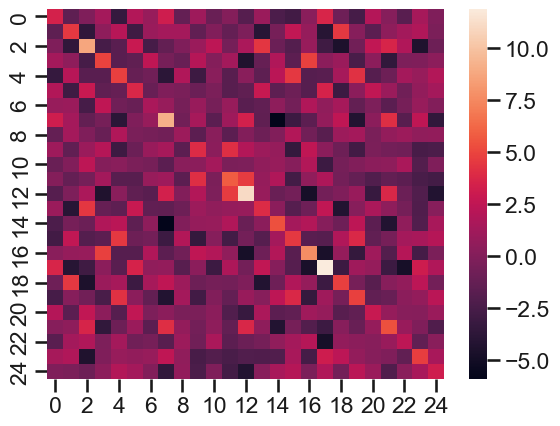

In [67]:
sns.heatmap(data_i@data_i.T)

<Axes: >

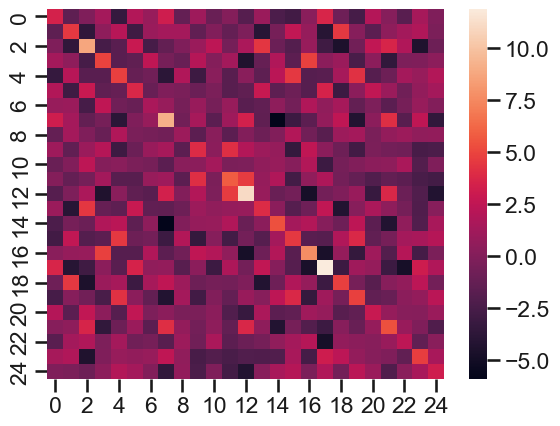

In [68]:
a = whiten(data_i)

sns.heatmap(a @ a.T)

In [69]:
np.linalg.norm(a@a.T - np.eye(a.shape[0]))

54.610300692938985

<Axes: >

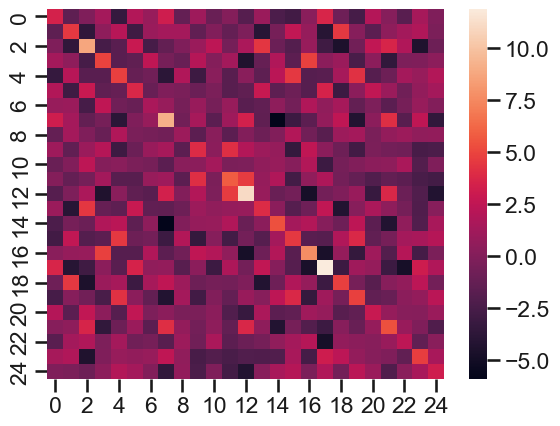

In [70]:
sns.heatmap(a@a.T)

<Axes: >

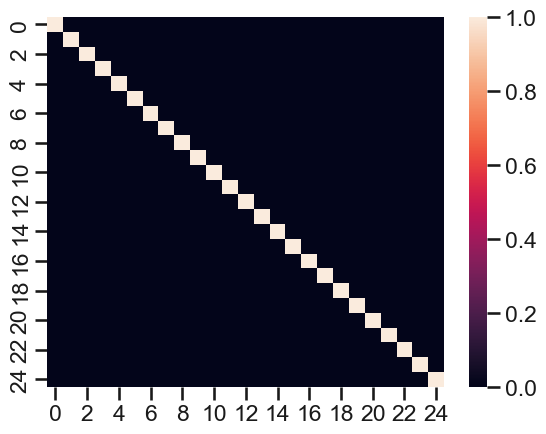

In [71]:
sns.heatmap(np.eye(a.shape[0]))

In [72]:
whiten(data_i)

array([[-1.0577182 , -0.47036108, -0.22574325, -1.3412032 ,  0.4667125 ],
       [ 0.21118009, -0.68433833, -1.151691  ,  1.0024155 , -1.2706497 ],
       [ 1.8195599 ,  1.2590564 ,  0.7861528 , -1.732971  ,  0.39915326],
       [-1.4094265 ,  0.9138225 , -1.3973076 ,  0.12887245,  0.30018348],
       [ 0.383505  ,  0.10841314,  0.82612026,  1.6067158 , -1.1616478 ],
       [-0.34631407,  0.05680029,  1.303547  , -1.3754566 , -0.01407001],
       [-0.8443076 , -0.02663388, -0.8674164 ,  0.23729871,  0.09834968],
       [ 0.15868512, -2.3509915 , -1.3237491 , -1.2638342 ,  0.4334649 ],
       [ 0.39704415, -0.10109457,  0.19136886,  0.35871014, -0.82759285],
       [ 0.07763459,  0.380438  , -0.98092455, -0.23684245,  1.6575681 ],
       [ 0.71476847,  0.8851092 , -0.18832384, -0.09619175, -0.1779211 ],
       [ 0.1738714 , -0.06734181, -0.60806644,  0.7149775 ,  2.2024977 ],
       [ 2.20522   , -1.5662628 ,  0.3471105 ,  0.7825517 ,  1.7283713 ],
       [ 0.2586917 ,  0.71420336,  1.1

In [73]:
data_i

Array([[-1.0577182 , -0.47036108, -0.22574325, -1.3412032 ,  0.4667125 ],
       [ 0.21118009, -0.68433833, -1.151691  ,  1.0024155 , -1.2706497 ],
       [ 1.8195599 ,  1.2590564 ,  0.7861528 , -1.732971  ,  0.39915326],
       [-1.4094265 ,  0.9138225 , -1.3973076 ,  0.12887245,  0.30018348],
       [ 0.383505  ,  0.10841314,  0.82612026,  1.6067158 , -1.1616478 ],
       [-0.34631407,  0.05680029,  1.303547  , -1.3754566 , -0.01407001],
       [-0.8443076 , -0.02663388, -0.8674164 ,  0.23729871,  0.09834968],
       [ 0.15868512, -2.3509915 , -1.3237491 , -1.2638342 ,  0.4334649 ],
       [ 0.39704415, -0.10109457,  0.19136886,  0.35871014, -0.82759285],
       [ 0.07763459,  0.380438  , -0.98092455, -0.23684245,  1.6575681 ],
       [ 0.71476847,  0.8851092 , -0.18832384, -0.09619175, -0.1779211 ],
       [ 0.1738714 , -0.06734181, -0.60806644,  0.7149775 ,  2.2024977 ],
       [ 2.20522   , -1.5662628 ,  0.3471105 ,  0.7825517 ,  1.7283713 ],
       [ 0.2586917 ,  0.71420336,  1.1

In [74]:
X  = np.array([[1.9, 2.3, 1.7],
                      [1.5, 2.5, 2.2],
                      [0.8, 0.6, 1.7,]])

In [75]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

ModuleNotFoundError: No module named 'sklearn'

In [76]:
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

pca = PCA(whiten=True)
X_whitened = pca.fit_transform(X_standardized)

NameError: name 'StandardScaler' is not defined

In [77]:
b@b.T

NameError: name 'b' is not defined

In [78]:
X

array([[1.9, 2.3, 1.7],
       [1.5, 2.5, 2.2],
       [0.8, 0.6, 1.7]])

In [79]:
X_whitened@X_whitened.T

NameError: name 'X_whitened' is not defined